<a href="https://colab.research.google.com/github/jairomartinezgiraldo/CNN/blob/main/InceptionV3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Importar librerías necesarias
import os
from google.colab import files
from google.colab import drive
import zipfile
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau # Importar los callbacks
from tensorflow.keras.applications import InceptionV3 ############## Nuevo modelo

# Carga - Conectar Google Drive y Descargar el Dataset


In [ ]:

# Descargar el dataset de Yoga desde Kaggle
!kaggle datasets download -d tr1gg3rtrash/yoga-posture-dataset

# Descomprimir el archivo descargado
import zipfile
with zipfile.ZipFile('yoga-posture-dataset.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/yoga_dataset')

print("Dataset descargado y extraído exitosamente.")


Dataset URL: https://www.kaggle.com/datasets/tr1gg3rtrash/yoga-posture-dataset
License(s): CC0-1.0
 96% 430M/447M [00:01<00:00, 231MB/s]
100% 447M/447M [00:01<00:00, 244MB/s]
Dataset descargado y extraído exitosamente.


In [ ]:
# Nuevo almacenamiento
#drive.mount('/content/drive')

base_dir = '/content/yoga_dataset'
inception_base_dir = '/content/drive/MyDrive/yoga_pose_classification_inception_'
os.makedirs(inception_base_dir, exist_ok=True)
os.makedirs(f"{inception_base_dir}/results", exist_ok=True)
os.makedirs(f"{inception_base_dir}/models", exist_ok=True)
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# Inspección - Análisis del dataset



*   Verificación de las subcarpetas del dataset, observando las diferentes clases de posturas de yoga.
*   Cada clase tiene un numero distinto de imagenes.
* A partir del dataset identificar y reconocer las distintas poses de yoga.



In [ ]:
subfolders = [f for f in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, f))]
print(f"Total de clases: {len(subfolders)}")
print("Clases encontradas:", subfolders)

Total de clases: 47
Clases encontradas: ['Ardha Chandrasana', 'Dhanurasana', 'Pincha Mayurasana', 'Trikonasana', 'Eka Pada Rajakapotasana', 'Virabhadrasana Two', 'Sivasana', 'Utkatasana', 'Garudasana', 'Baddha Konasana', 'Salamba Bhujangasana', 'Halasana', 'Utthita Hasta Padangusthasana', 'Bakasana', 'Virabhadrasana Three', 'Navasana', 'Urdhva Dhanurasana', 'Setu Bandha Sarvangasana', 'Uttanasana', 'Padmasana', 'Adho Mukha Svanasana', 'Utthita Parsvakonasana', 'Ardha Pincha Mayurasana', 'Ashta Chandrasana', 'Urdhva Mukha Svsnssana', 'Camatkarasana', 'Malasana', 'Paschimottanasana', 'Parsvottanasana', 'Ustrasana', 'Balasana', 'Anjaneyasana', 'Vasisthasana', 'Ardha Navasana', 'Adho Mukha Vrksasana', 'Hanumanasana', 'Ardha Matsyendrasana', 'Vrksasana', 'Upavistha Konasana', 'Supta Kapotasana', 'Phalakasana', 'Virabhadrasana One', 'Salamba Sarvangasana', 'Marjaryasana', 'Bitilasana', 'Parsva Virabhadrasana', 'Alanasana']


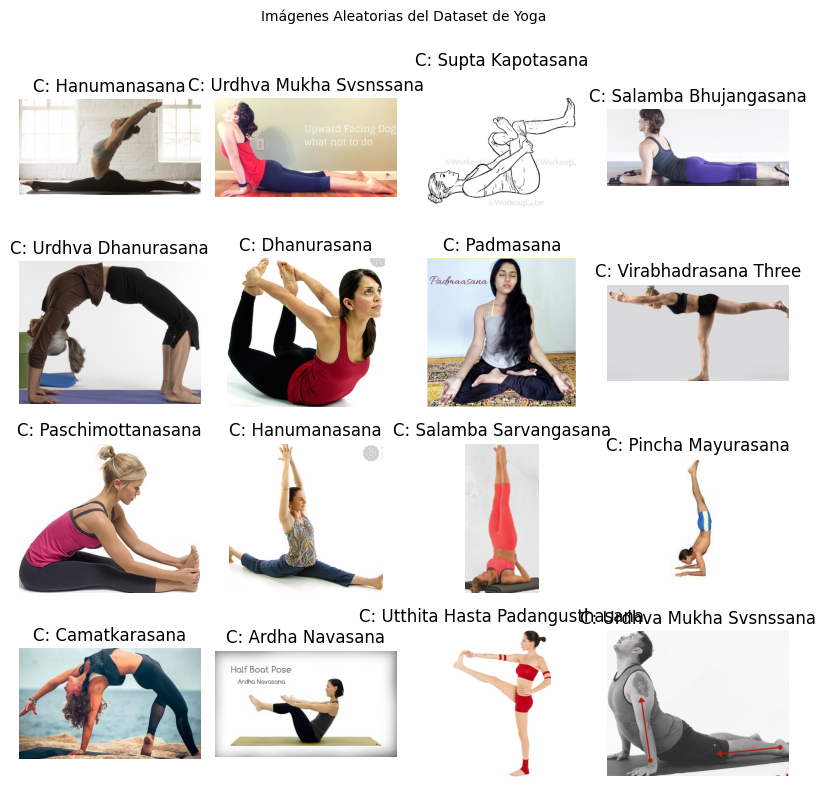

In [ ]:
fig, axes = plt.subplots(4, 4, figsize=(8, 8))
fig.suptitle('Imágenes Aleatorias del Dataset de Yoga', fontsize=10)

for ax in axes.flatten():
    chosen_folder = np.random.choice(subfolders)
    subfolder_path = os.path.join(base_dir, chosen_folder)

    # Verificar que la carpeta contiene imágenes, podemos observar distintos formatos de imagenes.
    images = [img for img in os.listdir(subfolder_path) if img.endswith(('.png', '.jpeg', '.jpg'))]
    if not images:  # Si la carpeta está vacía o no tiene imágenes, salta esta iteración
        ax.set_title('Sin imágenes')
        ax.axis('off')
        continue

    # Seleccionamos imagenes aleatoria para verificar la correcta carga de imagenes.
    img_name = np.random.choice(images)
    img_path = os.path.join(subfolder_path, img_name)

    # Mostramos las imagenes.
    img = cv2.imread(img_path)
    if img is not None:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        ax.imshow(img)
        ax.axis('off')
        ax.set_title(f"C: {chosen_folder}")
    else:
        ax.set_title('Imagen no encontrada')
        ax.axis('off')

plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()

# Acondicionamiento - preprocesamiento de imágenes



* Configuración de ImageDataGenerator para Entrenamiento, Validación y Prueba
* Habilitamos generadores de datos para entrenamiento y validación





In [ ]:
IMG_SIZE = (224, 224)

# Configuración del aumento de datos para el conjunto de entrenamiento
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.3  # Dividir el dataset en 70% entrenamiento y 30% (para validación y prueba)
)

# Generador de datos para el conjunto de entrenamiento (70% del total)
# Usamos flow_from_directory mejorar la eficiencia
train_generator = train_datagen.flow_from_directory(
    '/content/yoga_dataset',
    target_size=IMG_SIZE,
    batch_size=32,
    class_mode='categorical',
    subset='training',
    color_mode='rgb'  # RGB para InceptionV3
)

# Generador de datos para el conjunto de validación (15% del total)
val_datagen = ImageDataGenerator(rescale=1.0/255, validation_split=0.5)
val_generator = val_datagen.flow_from_directory(
    '/content/yoga_dataset',
    target_size=IMG_SIZE,
    batch_size=32,
    class_mode='categorical',
    subset='validation',
    color_mode='rgb'
)

# Generador de datos para el conjunto de prueba (15% del total)
test_datagen = ImageDataGenerator(rescale=1.0/255, validation_split=0.5)
test_generator = test_datagen.flow_from_directory(
    '/content/yoga_dataset',
    target_size=IMG_SIZE,
    batch_size=32,
    class_mode='categorical',
    subset='validation',
    color_mode='rgb',
    shuffle=False  # Matener orden de las clases
)

Found 1953 images belonging to 47 classes.
Found 1366 images belonging to 47 classes.
Found 1366 images belonging to 47 classes.


#  Arquitectura - **InceptionV3**  --------- de aqui en adelente todo es nuevo

# Definición de callbacks - Transfer Learning - InceptionV3

In [ ]:

inception_model_path = f"{inception_base_dir}/models/best_inception_model.keras"

inception_early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

inception_model_checkpoint = ModelCheckpoint(
    inception_model_path,
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)

inception_reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,
    min_lr=1e-6,
    verbose=1
)

inception_callbacks = [inception_early_stopping, inception_model_checkpoint, inception_reduce_lr]


# Desarrollo de la arquitectura - Transfer Learning - InceptionV3

In [ ]:
# Paso 2: Cargar el modelo base InceptionV3 con pesos de ImageNet
inception_base = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
inception_base.trainable = False  # Congelar el modelo base para el primer entrenamiento

# Paso 3: Construir las capas adicionales para la clasificación
x = inception_base.output
x = layers.Flatten()(x)
x = layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.5)(x)
inception_predictions = layers.Dense(47, activation='softmax')(x)  # 47 clases de yoga

# Definir el modelo completo
inception_model = Model(inputs=inception_base.input, outputs=inception_predictions)

# Paso 4: Compilar el modelo
inception_model.compile(optimizer=Adam(learning_rate=0.0001),
                        loss='categorical_crossentropy',
                        metrics=['accuracy'])

# Entrenamiento inicial

inception_history = inception_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20,
    callbacks=inception_callbacks
)

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


16/62 ━━━━━━━━━━━━━━━━━━━━ 39s 857ms/step - accuracy: 0.0450 - loss: 9.9922 

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 549ms/step - accuracy: 0.0630 - loss: 9.5206
Epoch 1: val_accuracy improved from -inf to 0.29283, saving model to /content/drive/MyDrive/yoga_pose_classification_inception_/models/best_inception_model.keras
62/62 ━━━━━━━━━━━━━━━━━━━━ 81s 949ms/step - accuracy: 0.0634 - loss: 9.5132 - val_accuracy: 0.2928 - val_loss: 7.9342 - learning_rate: 1.0000e-04
Epoch 2/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 444ms/step - accuracy: 0.2038 - loss: 7.9374
Epoch 2: val_accuracy improved from 0.29283 to 0.43851, saving model to /content/drive/MyDrive/yoga_pose_classification_inception_/models/best_inception_model.keras
62/62 ━━━━━━━━━━━━━━━━━━━━ 41s 620ms/step - accuracy: 0.2041 - loss: 7.9354 - val_accuracy: 0.4385 - val_loss: 6.7674 - learning_rate: 1.0000e-04
Epoch 3/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 446ms/step - accuracy: 0.3097 - loss: 7.2358
Epoch 3: val_accuracy improved from 0.43851 to 0.50952, saving model to /content/drive/MyDrive/yoga_pose_classification_inception_/mod

# Evaluación y Graficación de Métricas- Transfer Learning -InceptionV3
 -

In [ ]:
# Evaluación en Transfer Learning
inception_results = inception_model.evaluate(test_generator, verbose=0)
print(f"InceptionV3 Test Loss: {inception_results[0]}")
print(f"InceptionV3 Test Accuracy: {inception_results[1] * 100:.2f}%")

#Generar Reporte de Clasificación
from sklearn.metrics import classification_report

inception_predictions = inception_model.predict(test_generator, batch_size=128)
print("Reporte de Clasificación - Fine-Tuning (InceptionV3):")
print(classification_report(test_generator.classes, inception_predictions.argmax(axis=1), target_names=test_generator.class_indices.keys()))


InceptionV3 Test Loss: 3.222041368484497
InceptionV3 Test Accuracy: 72.04%
43/43 ━━━━━━━━━━━━━━━━━━━━ 17s 299ms/step
Reporte de Clasificación - Fine-Tuning (InceptionV3):
                               precision    recall  f1-score   support

         Adho Mukha Svanasana       0.65      0.81      0.72        37
         Adho Mukha Vrksasana       0.62      0.66      0.64        32
                    Alanasana       0.50      0.22      0.31         9
                 Anjaneyasana       0.65      0.43      0.52        35
            Ardha Chandrasana       0.86      0.62      0.72        29
         Ardha Matsyendrasana       0.68      0.85      0.76        48
               Ardha Navasana       1.00      0.17      0.29         6
      Ardha Pincha Mayurasana       1.00      0.22      0.36        27
            Ashta Chandrasana       0.33      0.17      0.22         6
              Baddha Konasana       0.80      0.70      0.75        40
                     Bakasana       0.93      0

**Graficas**

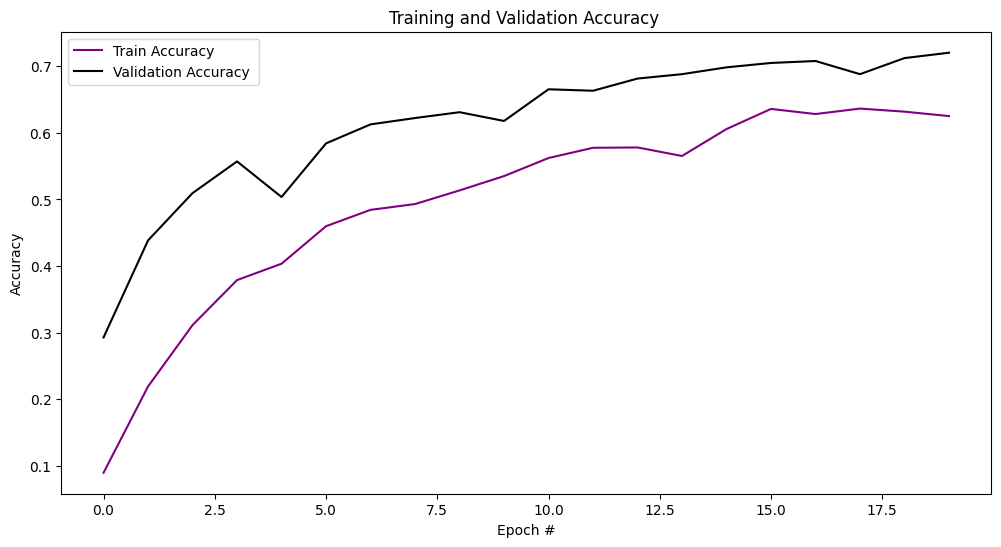

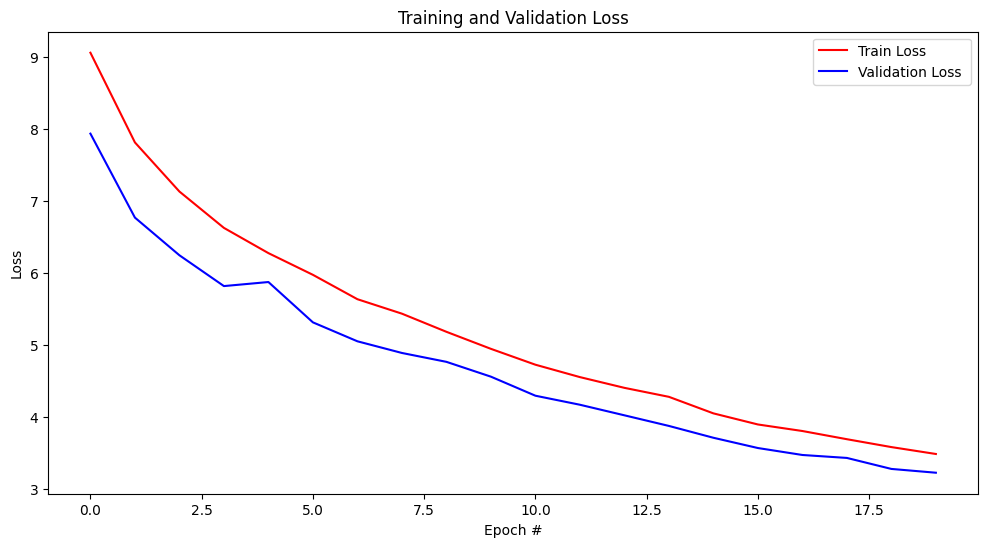

In [ ]:
# Graficar Accuracy de entrenamiento y validación
plt.figure(figsize=(12, 6))
plt.plot(inception_history.history["accuracy"], label="Train Accuracy ", color='purple')
plt.plot(inception_history.history["val_accuracy"], label="Validation Accuracy ", color='black')
plt.title("Training and Validation Accuracy ")
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.legend(loc="best")
plt.show()

# Graficar Loss de entrenamiento y validación
plt.figure(figsize=(12, 6))
plt.plot(inception_history.history["loss"], label="Train Loss ", color='red')
plt.plot(inception_history.history["val_loss"], label="Validation Loss ", color='blue')
plt.title("Training and Validation Loss")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="best")
plt.show()

# Desarrollo de la arquitectura - Fine Tuning - InceptionV3

In [ ]:
# Fine-Tuning (descongelar algunas capas superiores de )
inception_base.trainable = True
fine_tune_at = 200  # Ajusta el número según el comportamiento del modelo

for layer in inception_base.layers[:fine_tune_at]:
    layer.trainable = False

# Compilar nuevamente con una tasa de aprendizaje baja para el fine-tuning
inception_model.compile(optimizer=Adam(learning_rate=1e-5),
                        loss='categorical_crossentropy',
                        metrics=['accuracy'])

# Fine-tuning
inception_history_fine = inception_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=15,
    callbacks=inception_callbacks
)

Epoch 1/15


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 646ms/step - accuracy: 0.4346 - loss: 4.2119
Epoch 1: val_accuracy improved from 0.72035 to 0.72328, saving model to /content/drive/MyDrive/yoga_pose_classification_inception_/models/best_inception_model.keras
62/62 ━━━━━━━━━━━━━━━━━━━━ 96s 962ms/step - accuracy: 0.4348 - loss: 4.2103 - val_accuracy: 0.7233 - val_loss: 3.0753 - learning_rate: 1.0000e-05
Epoch 2/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step - accuracy: 0.4765 - loss: 3.8939
Epoch 2: val_accuracy did not improve from 0.72328
62/62 ━━━━━━━━━━━━━━━━━━━━ 40s 588ms/step - accuracy: 0.4766 - loss: 3.8932 - val_accuracy: 0.7145 - val_loss: 3.0343 - learning_rate: 1.0000e-05
Epoch 3/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 468ms/step - accuracy: 0.5086 - loss: 3.6867
Epoch 3: val_accuracy did not improve from 0.72328
62/62 ━━━━━━━━━━━━━━━━━━━━ 40s 595ms/step - accuracy: 0.5089 - loss: 3.6853 - val_accuracy: 0.6808 - val_loss: 3.0820 - learning_rate: 1.0000e-05
Epoch 4/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 456ms/s

# Evaluación y Graficación de Métricas- Fine Tuning - InceptionV3

In [ ]:
# Evaluación en el conjunto de prueba
inception_results = inception_model.evaluate(test_generator, verbose=0)
print(f"InceptionV3 Test Loss: {inception_results[0]}")
print(f"InceptionV3 Test Accuracy: {inception_results[1] * 100:.2f}%")

# enerar Reporte de Clasificación
from sklearn.metrics import classification_report

inception_predictions = inception_model.predict(test_generator, batch_size=128)
print("Reporte de Clasificación - Fine-Tuning (InceptionV3):")
print(classification_report(test_generator.classes, inception_predictions.argmax(axis=1), target_names=test_generator.class_indices.keys()))


InceptionV3 Test Loss: 2.4724338054656982
InceptionV3 Test Accuracy: 77.82%
43/43 ━━━━━━━━━━━━━━━━━━━━ 17s 298ms/step
Reporte de Clasificación - Fine-Tuning (InceptionV3):
                               precision    recall  f1-score   support

         Adho Mukha Svanasana       0.78      0.78      0.78        37
         Adho Mukha Vrksasana       0.82      0.72      0.77        32
                    Alanasana       0.60      0.33      0.43         9
                 Anjaneyasana       0.71      0.69      0.70        35
            Ardha Chandrasana       0.88      0.76      0.81        29
         Ardha Matsyendrasana       0.75      0.85      0.80        48
               Ardha Navasana       0.80      0.67      0.73         6
      Ardha Pincha Mayurasana       0.70      0.59      0.64        27
            Ashta Chandrasana       0.50      0.33      0.40         6
              Baddha Konasana       0.67      0.75      0.71        40
                     Bakasana       0.87      

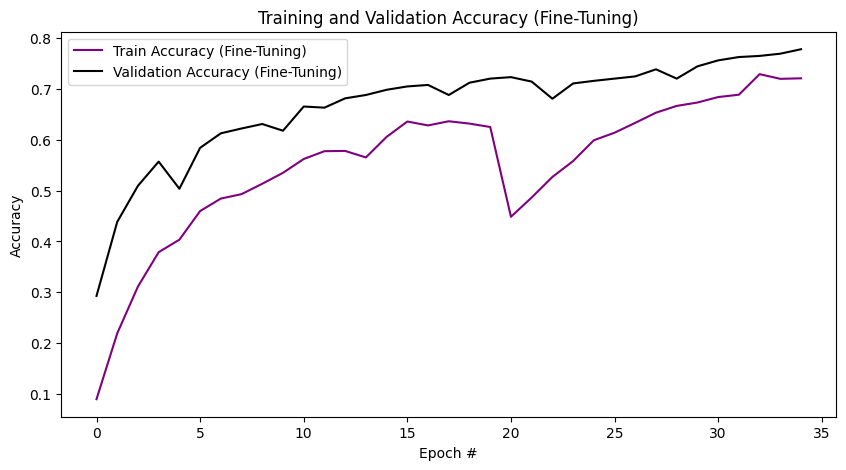

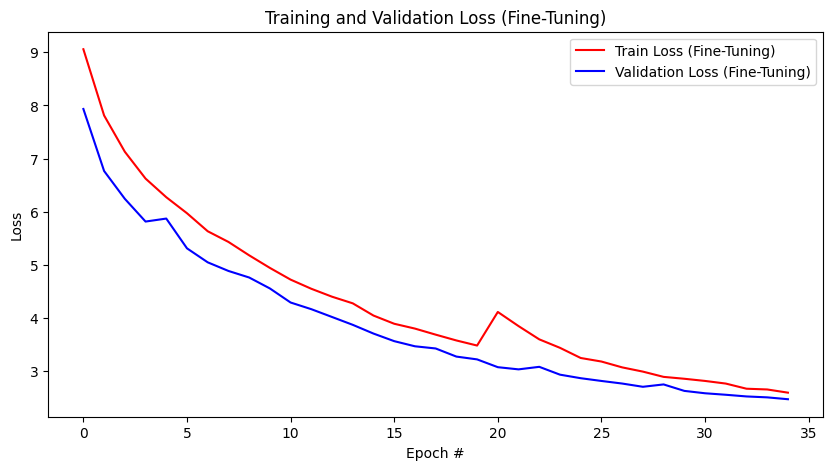

In [ ]:

# Graficar precisión de entrenamiento y validación
plt.figure(figsize=(10, 5))
plt.plot(inception_history.history['accuracy'] + inception_history_fine.history['accuracy'], label="Train Accuracy (Fine-Tuning)", color='purple')
plt.plot(inception_history.history['val_accuracy'] + inception_history_fine.history['val_accuracy'], label="Validation Accuracy (Fine-Tuning)", color='black')
plt.title("Training and Validation Accuracy (Fine-Tuning)")
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

# Graficar pérdida de entrenamiento y validación
plt.figure(figsize=(10, 5))
plt.plot(inception_history.history['loss'] + inception_history_fine.history['loss'], label="Train Loss (Fine-Tuning)", color='red')
plt.plot(inception_history.history['val_loss'] + inception_history_fine.history['val_loss'], label="Validation Loss (Fine-Tuning)", color='blue')
plt.title("Training and Validation Loss (Fine-Tuning)")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend()
plt.show()